<a href="https://colab.research.google.com/github/Sulbae/Study-Material/blob/main/Sentimen_Analisis_Ruangguru_Clash_of_Champions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentimen Analisis Clash of Champions oleh Ruangguru

Proyek ini akan melakukan analisis sentimen terhadap tayangan Clash of Champions oleh Ruangguru yang ditayangkan di Youtube

## Install dan Import Library

Karena bahasa-bahasa pada kolom komentar mayoritas Bahasa Indonesia tetapi terdapat beberapa bahasa Inggris, maka akan digunakan library `googletrans` untuk translate seluruh komentar ke bahasa Inggris dan library `sastrawi` untuk preproses komentar berbahasa Indonesia.

In [ ]:
!pip install googletrans==3.1.0a0
!pip install sastrawi

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 2.6 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16352 sha256=522d9c9480bb178a4eeeb8df12ef9150089bc48a9faaf63af9107373a3d6def4
  Stored in directory: /root/.cache/pip/wheels/50/5d/3c/8477d0af4ca2b8b1308812c09f1930863caeebc762fe265a95
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
 

Selanjutnya, kita mengimpor seluruh library yang diperlukan pada proyek ini.

In [ ]:
import re
import string
import csv
import nltk
import requests
import textblob
import googletrans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
from textblob import TextBlob
from googletrans import Translator
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Data Gathering

Selanjutnya, kita mengimpor dataset yang sudah discrape menjadi file bernama `seluruh_komen.csv`

In [ ]:
data = pd.read_csv("/content/seluruh_komen.csv")
data.head(10)

,author,comment
0,@Ruangguru,"Yuk, konsultasi dan klaim diskonnya sekarang d..."
1,@Saphscorner,Yesaya : eh lagi interview ya😂😂😂😂
2,@nurafif4610,Lucu banget takut dihujat😭
3,@Elvira_aqila,Baru nyadar gw ada kevin di di foto icho nya i...
4,@CadusiNemo,Yesaya belagu
5,@farukfadino1233,"Gppa cuma penonton, setidaknya yg saya dan yg ..."
6,@MuhammadSyadidan-o5r,Ada yang makan cimori yogurt
7,@TanjungOdi,Apa sih banyak yg pintar kayak pengen masuk ke...
8,@sotomo1949,8.32 bang Maxwell?🗿 omongan nya kaya Jawa aja
9,@JeyAuto-dv5op,Ada guru aku😮


# Data Assessing & Cleaning

In [ ]:
# Menampilkan informasi umum terkait data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84935 entries, 0 to 84934
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   author   84933 non-null  object
 1   comment  84935 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


Dari hasil info di atas, terlihat bahwa kolom `comment` memiliki 84935 baris yang non-null dan kolom `author` memiliki 84933 baris yang non-null. Artinya, ada 2 data bernilai null, sehingga akan diperiksa apakah terdapat duplikasi data dan data yang bernilai null.

In [ ]:
# Menghitung jumlah data duplikat
data.duplicated().sum()

951

Terlihat bahwa terdapat 951 data duplikat. Akan diperiksa data-data duplikat tersebut apakah memang duplikat atau tidak.

In [ ]:
# Menampilkan data duplikat
data[data.duplicated]

,author,comment
255,@WatashiFannann,Goofy ah!
452,@nurdinsans384,Hanif kertasnya kosong gak ada coretan 🗿pertam...
563,@rendlessism,Ngeri ya ITB
828,@SamsungUtama-r6k,Ya allah yg ke tiga ngeliatnya aja udh pusing😭
889,@tahsigungreti8816,"Sambil nangis dari awal nonton, karena mikir k..."
...,...,...
84662,@bbellabell,"TIM AXEELLL, BUT I&#39;M ALWAYS SUPPORT SHAKIRAA"
84664,@bbellabell,"TIM AXEELLL, BUT I&#39;M ALWAYS SUPPORT SHAKIRAA"
84722,@asra691,ayoooo
84809,@nontoon_toon,"<a href=""https://www.youtube.com/playlist?list..."


Karena terdapat data duplikat, maka data duplikat akan dihapus.

In [ ]:
# Menghapus data duplikat, lalu menampilkan informasi data setelah data duplikat dihapus
data.drop_duplicates(inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83984 entries, 0 to 84934
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   author   83982 non-null  object
 1   comment  83984 non-null  object
dtypes: object(2)
memory usage: 1.9+ MB


Selanjutnya, kita akan memeriksa data yang memiliki nilai null kolom `author`.

In [ ]:
# Menghitung jumlah data bernilai null
data.isna().sum()

,0
author,2
comment,0


Terdapat 2 baris yang memiliki nilai null pada kolom `author`. Akan kita periksa 2 baris tersebut.

In [ ]:
data[data.isna().any(axis = 1)]

,author,comment
67341,NaN,Kadit kamu luar biasa 🔥
74126,NaN,shakira pliss


Karena seharusnya ada penulis yang memberikan komen, maka kedua baris ini akan dihapus.

In [ ]:
# Menghapus data duplikat, lalu menampilkan informasi data setelah data duplikat dihapus
data.dropna(inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83982 entries, 0 to 84934
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   author   83982 non-null  object
 1   comment  83982 non-null  object
dtypes: object(2)
memory usage: 1.9+ MB


Data selanjutnya dapat digunakan untuk diproses maupun dianalisa

## Data Preprocessing

Kita akan memproses data agar dapat dianalisa dan dilatih dengan Machine Learning.

In [ ]:
# Membuat set berisi seluruh kata-kata tidak baku, typo, maupun slang words
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin"}

# Membuat fungsi untuk memperbaiki kata-kata, mengembalikan hasil berupa kata yang telah diperbaiki
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [ ]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # Menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # Menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # Menghapus RT
    text = re.sub(r"http\S+", '', text) # Menghapus link
    text = re.sub(r'[0-9]+', '', text) # Menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # Menghapus karakter selain huruf dan angka
    text = text.replace('\n', ' ') # Mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # Menghapus semua tanda baca
    text = text.strip(' ') # Menghapus karakter spasi dari kiri dan kanan teks
    return text

# Mengubah semua karakter dalam teks menjadi huruf kecil
def casefoldingText(text):
    text = text.lower()
    return text

# Memecah atau membagi string, teks menjadi daftar token
def tokenizingText(text):
    text = word_tokenize(text)
    return text

# Menghapus stopwords dalam teks
def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)

    # List stopwords dapat ditambah lagi jika menemukan
    listStopwords.update(["iya", "yaa", "gak", "nya", "na", "sih", "ku", "di",
                          "ga", "ya", "gaa", "loh", "kah", "woi", "woii", "woy",
                          "yuk", "br", "ulm"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

# Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
def stemmingText(text):
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = " ".join(stemmed_words)

    return stemmed_text

# Mengubah daftar kata menjadi kalimat
def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [ ]:
# Membersihkan teks dan menyimpannya di kolom "text_clean"
data["text_clean"] = data["comment"].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di "text_casefoldingText"
data["text_casefoldingText"] = data["text_clean"].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di "text_slangwords"
data["text_slangwords"] = data["text_casefoldingText"].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di "text_tokenizingText"
data["text_tokenizingText"] = data["text_slangwords"].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di "text_stopword"
data["text_stopword"] = data["text_tokenizingText"].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di "text_akhir"
data["text_akhir"] = data["text_stopword"].apply(toSentence)

Selanjutnya, kita akan mengubah bahasa pada komentar menjadi bahasa Inggris seluruhnya.

In [ ]:
df = pd.DataFrame(data.text_akhir)

# Memanggil Translator() dari library googletrans
translator = Translator()
translations = {}

# Menerjemahkan komentar
for column in df.columns:
    # Mendapatkan kata-kata unik(hanya ada 1) dari setiap kolom
    unique_elements = df[column].unique()
    for element in unique_elements:
        # Memasukkan terjemahan ke kamus
        translations[element] = translator.translate(element).text

# Memasukkann hasil terjemahan ke kolom baru, yaitu translated_text
data["translated_text"] = df.replace(translations)

data.head(10)

,author,comment,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir,translated_text
0,@Ruangguru,"Yuk, konsultasi dan klaim diskonnya sekarang d...",Yuk konsultasi dan klaim diskonnya sekarang di...,yuk konsultasi dan klaim diskonnya sekarang di...,yuk konsultasi dan klaim diskonnya sekarang di...,"[yuk, konsultasi, dan, klaim, diskonnya, sekar...","[konsultasi, klaim, diskonnya, href]",konsultasi klaim diskonnya href,discount claim consultation href
1,@Saphscorner,Yesaya : eh lagi interview ya😂😂😂😂,Yesaya eh lagi interview ya,yesaya eh lagi interview ya,yesaya eh lagi interview iya,"[yesaya, eh, lagi, interview, iya]","[yesaya, eh, interview]",yesaya eh interview,"yes, uh, interview"
2,@nurafif4610,Lucu banget takut dihujat😭,Lucu banget takut dihujat,lucu banget takut dihujat,lucu banget takut dihujat,"[lucu, banget, takut, dihujat]","[lucu, banget, takut, dihujat]",lucu banget takut dihujat,it's really funny to be afraid of being blasph...
3,@Elvira_aqila,Baru nyadar gw ada kevin di di foto icho nya i...,Baru nyadar gw ada kevin di di foto icho nya i...,baru nyadar gw ada kevin di di foto icho nya i...,baru nyadar saya ada kevin di di foto icho nya...,"[baru, nyadar, saya, ada, kevin, di, di, foto,...","[nyadar, kevin, foto, icho, imelda, kevinnnnbr...",nyadar kevin foto icho imelda kevinnnnbrsumpah...,"I realized that Kevin, Icho Imelda's photo, I ..."
4,@CadusiNemo,Yesaya belagu,Yesaya belagu,yesaya belagu,yesaya belagu,"[yesaya, belagu]","[yesaya, belagu]",yesaya belagu,Yesaya is confused
5,@farukfadino1233,"Gppa cuma penonton, setidaknya yg saya dan yg ...",Gppa cuma penonton setidaknya yg saya dan yg k...,gppa cuma penonton setidaknya yg saya dan yg k...,gppa cuma penonton setidaknya yang saya dan ya...,"[gppa, cuma, penonton, setidaknya, yang, saya,...","[gppa, penonton, komen, tontonannya, beredukas...",gppa penonton komen tontonannya beredukasimaju...,It doesn't matter if the audience comments tha...
6,@MuhammadSyadidan-o5r,Ada yang makan cimori yogurt,Ada yang makan cimori yogurt,ada yang makan cimori yogurt,ada yang makan cimori yogurt,"[ada, yang, makan, cimori, yogurt]","[makan, cimori, yogurt]",makan cimori yogurt,eat cimori yogurt
7,@TanjungOdi,Apa sih banyak yg pintar kayak pengen masuk ke...,Apa sih banyak yg pintar kayak pengen masuk ke...,apa sih banyak yg pintar kayak pengen masuk ke...,apa sih banyak yang pintar kayak pengen masuk ...,"[apa, sih, banyak, yang, pintar, kayak, pengen...","[pintar, kayak, pengen, masuk, kampusnya, gk]",pintar kayak pengen masuk kampusnya gk,"smart, like you want to go to college or not?"
8,@sotomo1949,8.32 bang Maxwell?🗿 omongan nya kaya Jawa aja,bang Maxwell omongan nya kaya Jawa aja,bang maxwell omongan nya kaya jawa aja,bang maxwell omongan nya kaya jawa saja,"[bang, maxwell, omongan, nya, kaya, jawa, saja]","[bang, maxwell, omongan, kaya, jawa]",bang maxwell omongan kaya jawa,Bang Maxwell talks like Javanese
9,@JeyAuto-dv5op,Ada guru aku😮,Ada guru aku,ada guru aku,ada guru aku,"[ada, guru, aku]",[guru],guru,guru


Setelah diproses, selanjutnya kita akan memberi label pada setiap komentar. Pada proyek ini, kita menggunakan polaritas untuk memberikan label pada data. Nilai polaritas memiliki skala dari -1 hingga 1.
* Jika polaritas < 0, maka komentar tersebut bersifat negatif
* Jika polaritas > 0, maka komentar tersebut bersifat positif
* Jika polaritas = 0, maka komentar tersebut bersifat netral

In [ ]:
# Mendefinisikan subjektifitas untuk menilai tingkat subjektif pada komentar
def subjektivitas(tr_text):
    return TextBlob(tr_text).sentiment.subjectivity

# Mendefinisikan polaritas untuk menilai tingkat polaritas pada komentar
def polaritas(tr_text):
    return TextBlob(tr_text).sentiment.polarity

# Mendefinisikan hasil sentimen untuk memberikan label pada komentar
def hasilSentimen(nilai):
    if nilai < 0:
        return "negatif"
    elif nilai > 0:
        return "positif"
    else:
        return "netral"

# Menambahkan kolom subjektivitas dengan mengaplikasikan fungsi subjektivitas
data["subjektivitas"] = data["translated_text"].apply(subjektivitas)

# Menambahkan kolom polaritas dengan mengaplikasikan fungsi polaritas
data["polaritas"] = data["translated_text"].apply(polaritas)

# Menambahkan kolom sentimen dengan mengaplikasikan fungsi hasil sentimen
data["sentimen"] = data["polaritas"].apply(hasilSentimen)

# Menampilkan 5 baris pertama data setelah diaplikasikan seluruh fungsi
data.head()

,author,comment,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir,translated_text,subjektivitas,polaritas,sentimen
0,@Ruangguru,"Yuk, konsultasi dan klaim diskonnya sekarang d...",Yuk konsultasi dan klaim diskonnya sekarang di...,yuk konsultasi dan klaim diskonnya sekarang di...,yuk konsultasi dan klaim diskonnya sekarang di...,"[yuk, konsultasi, dan, klaim, diskonnya, sekar...","[konsultasi, klaim, diskonnya, href]",konsultasi klaim diskonnya href,discount claim consultation href,0.00,0.000,netral
1,@Saphscorner,Yesaya : eh lagi interview ya😂😂😂😂,Yesaya eh lagi interview ya,yesaya eh lagi interview ya,yesaya eh lagi interview iya,"[yesaya, eh, lagi, interview, iya]","[yesaya, eh, interview]",yesaya eh interview,"yes, uh, interview",0.00,0.000,netral
2,@nurafif4610,Lucu banget takut dihujat😭,Lucu banget takut dihujat,lucu banget takut dihujat,lucu banget takut dihujat,"[lucu, banget, takut, dihujat]","[lucu, banget, takut, dihujat]",lucu banget takut dihujat,it's really funny to be afraid of being blasph...,0.95,-0.175,negatif
3,@Elvira_aqila,Baru nyadar gw ada kevin di di foto icho nya i...,Baru nyadar gw ada kevin di di foto icho nya i...,baru nyadar gw ada kevin di di foto icho nya i...,baru nyadar saya ada kevin di di foto icho nya...,"[baru, nyadar, saya, ada, kevin, di, di, foto,...","[nyadar, kevin, foto, icho, imelda, kevinnnnbr...",nyadar kevin foto icho imelda kevinnnnbrsumpah...,"I realized that Kevin, Icho Imelda's photo, I ...",0.25,0.250,positif
4,@CadusiNemo,Yesaya belagu,Yesaya belagu,yesaya belagu,yesaya belagu,"[yesaya, belagu]","[yesaya, belagu]",yesaya belagu,Yesaya is confused,0.70,-0.400,negatif


Selanjutnya, kita akan menghitung jumlah masing-masing sentimen dan memvisualisasikannya.

In [ ]:
# Menghitung jumlah masing-masing sentimen
data["sentimen"].value_counts()

,count
sentimen,
positif,38696
netral,36204
negatif,9082


Text(0.5, 1.0, 'Persentase Masing-Masing Sentimen')

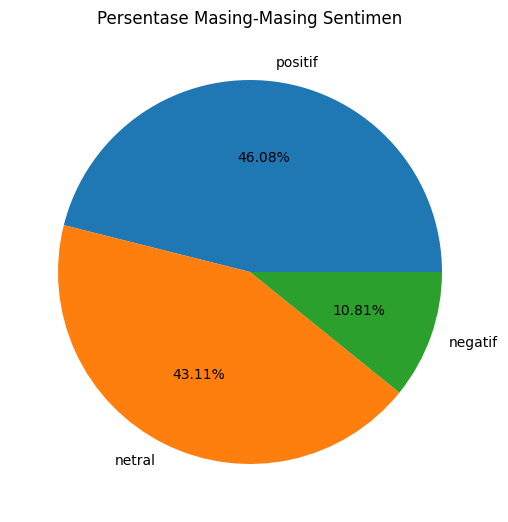

In [ ]:
diagram = data["sentimen"].value_counts().rename_axis("nilai_sentimen").reset_index(name = "jumlah")
label = diagram.nilai_sentimen
nilai = diagram.jumlah

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.axis = ("equal")

# Membentuk pie plot untuk menampilkan persentase masing-masing sentimen
ax.pie(nilai, labels = label, autopct = "%1.2f%%" )
ax.set_title("Persentase Masing-Masing Sentimen")

Dari hasil di atas, dapat dilihat bahwa sentimen positif berjumlah **38696** atau sekitar **46.08%** dari total, sentimen negatif berjumlah **9082** atau sekitar **10.81%** dari total, dan sentimen netral berjumlah **36204** atau sekitar dari **43.11%** total. Selanjutnya, kita akan menyimpan dataset yang telah diberi label.

In [ ]:
# Menyimpan dataset yang telah diberi label dalam file csv bernama seluruh_komen_berlabel
data.to_csv("seluruh_komen_berlabel.csv", encoding = "utf8", index = False)

## Data Processing dan Ekstraksi Fitur

Setelah data di preproses, kita akan memproses data untuk pelatihan model machine learning. Karena jumlah komentar negatif jauh lebih sedikit dibanding komentar positif maupun netral, maka kita akan melakukan oversampling data untuk komentar negatif. Pada proyek ini, komentar negatif akan dioversampling sehingga jumlahnya menjadi 28000 baris.

In [ ]:
# Mendefinisikan jumlah baris untuk komentar negatif
target_num_negatif = 37000

# Menghitung jumlah baris pada komentar negatif yang ada
current_num_negatif = data[data["sentimen"] == "negatif"].shape[0]

# Menghitung jumlah tambahan baris komentar negatif yang diperlukan
num_additional_negatif = target_num_negatif - current_num_negatif

# Melakukan oversampling pada komentar negatif
additional_negatif_samples = data[data["sentimen"] == "negatif"].sample(num_additional_negatif, replace = True)

# Menggabungkan komentar negatif yang asli dengan komentar negatif hasil oversampling
balanced_data = pd.concat([data, additional_negatif_samples], ignore_index = True)

# Menampilkan jumlah masing-masing sentimen setelah dilakukan oversampling
print(balanced_data["sentimen"].value_counts())

sentimen
positif    38696
negatif    37000
netral     36204
Name: count, dtype: int64


Setelah dilakukan oversampling, terlihat bahwa jumlah data pada masing-masing sentimen sudah berdekatan. Selanjutnya, kita akan melakukan ekstraksi fitur pada dataset menggunakan `TF-IDF`.

In [ ]:
# Memisahkan data menjadi fitur (comment) dan label (sentimen)
X = balanced_data["comment"]
y = balanced_data["sentimen"]

# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(max_features = 4000, min_df = 20, max_df = 0.8)
X_tfidf = tfidf.fit_transform(X)

# Konversi hasil ekstraksi fitur menjadi dataframe
features_df = pd.DataFrame(X_tfidf.toarray(), columns = tfidf.get_feature_names_out())

# Menampilkan hasil ekstraksi fitur
features_df

,00,02,04,05,06,07,08,09,10,100,...,youuu,yt,ytb,yu,yuk,yukk,yutub,zaman,zonk,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.473487,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
111896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
111897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
111898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


Setelah itu, kita akan mempersiapkan data untuk dilatih dengan membagi menjadi dua, yaitu data training dan data testing. Pada proyek ini, sebanyak 90% data masuk ke data traning dan 10% data masuk ke data testing.

In [ ]:
# Membagi data menjadi data latih dan data uji dengan train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size = 0.1, random_state = 50)

## Pemodelan

Setelah data siap untuk dilatih, kita akan memodelkan data menggunakan algoritma Random Forest.

In [ ]:
# Membuat objek model Random Forest
random_forest = RandomForestClassifier()

# Melatih model Random Forest pada data pelatihan
random_forest.fit(X_train.toarray(), y_train)

# Memprediksi sentimen pada data pelatihan dan data uji
y_pred_train_rf = random_forest.predict(X_train.toarray())
y_pred_test_rf = random_forest.predict(X_test.toarray())

# Mengevaluasi akurasi model Random Forest
accuracy_train_rf = accuracy_score(y_pred_train_rf, y_train)
accuracy_test_rf = accuracy_score(y_pred_test_rf, y_test)

# Menampilkan akurasi data training dan data testing
print("Random Forest - accuracy_train:", accuracy_train_rf)
print("Random Forest - accuracy_test:", accuracy_test_rf)

Random Forest - accuracy_train: 0.9879555158375534
Random Forest - accuracy_test: 0.8990169794459338


Dari hasil di atas, dapat dilihat bahwa model Random Forest memiliki akurasi training sebesar 98.79% dan akurasi testing sebesar 89.90%.

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier

# # Membuat objek model K-Nearest Neighbors
# knn = KNeighborsClassifier(n_neighbors = 10)

# # Melatih model K-Nearest Neighbors pada data pelatihan
# knn.fit(X_train.toarray(), y_train)

# # Memprediksi sentimen pada data pelatihan dan data uji
# y_pred_train_knn = knn.predict(X_train.toarray())
# y_pred_test_knn = knn.predict(X_test.toarray())

# # Mengevaluasi akurasi model K-Nearest Neighbors
# accuracy_train_knn = accuracy_score(y_pred_train_knn, y_train)
# accuracy_test_knn = accuracy_score(y_pred_test_knn, y_test)

# # Menampilkan akurasi data training dan data testing
# print("K-Nearest Neighbors - accuracy_train:", accuracy_train_knn)
# print("K-Nearest Neighbors - accuracy_test:", accuracy_test_knn)

## Inference Function

Kode di bawah ini dapat digunakan untuk menguji model yang telah dibuat dengan output berupa klasifikasi sentimen.

In [ ]:
# Mendefinisikan mapping untuk menampilkan output klasifikasi sentimen
label_mapping = {"positif": "Positif", "netral": "Netral", "negatif": "Negatif"}

# Memanggil fungsi Translator dari library googletrans
translator = Translator()

def translate_text(text, bahasa_asal = "id", bahasa_tujuan = "en"):
    """Menerjemahkan bahasa Indonesia menjadi bahasa Inggris"""
    translated = translator.translate(text, src = bahasa_asal, dest = bahasa_tujuan)
    return translated.text

def preprocess_input(text, tfidf_vectorizer):
    """Preprocess the input text to match the training data preprocessing."""
    text_tokenized = word_tokenize(text)
    text_transformed = tfidf_vectorizer.transform([" ".join(text_tokenized)])
    return text_transformed

def predict_sentiment(text, model, tfidf_vectorizer):
    """Predict the sentiment of the given text using the trained Random Forest model."""
    # Menerjemahkan teks input ke dalam bahasa Inggris
    translated_text = translate_text(text)

    # Preproses teks yang telah diterjemahkan
    preprocessed_text = preprocess_input(translated_text, tfidf_vectorizer)

    # Memastikan teks memiliki ukuran yang sesuai
    preprocessed_text_array = preprocessed_text.toarray()

    # Membuat prediksi teks
    prediction = model.predict(preprocessed_text_array)

    # Memprediksi teks ke sentimen yang sesuai
    predicted_sentiment = label_mapping[prediction[0]]

    return predicted_sentiment

# Memberikan input pada pengguna untuk memasukkan teks untuk diuji
input_text = input("Masukkan Teks: ")
predicted_sentiment = predict_sentiment(input_text, random_forest, tfidf)
print(f"Predicted Sentiment: {predicted_sentiment}")

Masukkan Teks: Saya Senang Menonton Clash of Champions
Predicted Sentiment: Positif


In [ ]:
!pip freeze requirements.txt

absl-py==1.4.0
accelerate==0.32.1
aiohttp==3.9.5
aiosignal==1.3.1
alabaster==0.7.16
albucore==0.0.12
albumentations==1.4.12
altair==4.2.2
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.5.1
arviz==0.18.0
asn1crypto==1.5.1
astropy==6.1.2
astropy-iers-data==0.2024.7.29.0.32.7
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==23.2.0
audioread==3.0.1
autograd==1.6.2
Babel==2.15.0
backcall==0.2.0
beautifulsoup4==4.12.3
bidict==0.23.1
bigframes==1.11.1
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.4.3
bqplot==0.12.43
branca==0.7.2
build==1.2.1
CacheControl==0.14.0
cachetools==5.4.0
catalogue==2.0.10
certifi==2024.7.4
cffi==1.16.0
chardet==3.0.4
charset-normalizer==3.3.2
chex==0.1.86
clarabel==0.9.0
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpathlib==0.18.1
cloudpickle==2.2.1
cmake==3.30.1
cmdstanpy==1.2.4
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.5
cons==0.4.6
c